# ToDo: 
+ ~~期待値がほぼ 0 になっている理由を探す。回避できるようなら回避~~
+ ~~C = 3 * n_qubits の理由~~ (特に理由はない？)
+ ~~QPU のばらつき改善~~
+ ~~2 次のトロッターにしてみる~~
+ ~~GHZ を中心に寄せる。このままだと不要な Trotter gate があるので。~~
+ 不要な interaction を削除

## わかったこと
+ ハミルトニアンをシフトさせなければ成功
+ times = [2 * np.pi * k / C for k in range(n_features)] は失敗
+ times = [np.pi * k / C for k in range(n_features)] は成功

In [1]:
%matplotlib inline
%pip freeze > requirements.txt
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Add the fourier_learning_ibm package to the path
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

['/home/jovyan',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/fourier_learning_ibm/']


In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import os
from heisenberg_graph import (
    HeisenbergModel,
    get_n_steps,
    get_graph,
    get_positions,
    get_initial_layout,
    get_prob0,
    extract_probs,
)
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Batch
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
import mthree
import pickle
import networkx as nx
from datetime import datetime, timezone
import json
import math

In [4]:
# Set up the Qiskit Runtime service (this is an one-time setup)
# QiskitRuntimeService.save_account(
#     token="YOUR_API_TOKEN",
#     channel="ibm_quantum",
# )

In [5]:
# Option1: Use IBM Quantum backend.
# Load saved credentials
service = QiskitRuntimeService()
# backend_qpu = service.least_busy(simulator=False, interactional=True)
backend_qpu = service.backend("ibm_marrakesh")

# Option2: Use local AerSimulator as the backend.
backend_sim = AerSimulator()

noise_model = NoiseModel.from_backend(backend_qpu)
backend_sim_noisy = AerSimulator(noise_model=noise_model)

print(f"Using backend QPU: {backend_qpu}")
print(f"Using backend simulator: {backend_sim}")
print(f"Using backend noisy simulator: {backend_sim_noisy}")

Using backend QPU: <IBMBackend('ibm_marrakesh')>
Using backend simulator: AerSimulator('aer_simulator')
Using backend noisy simulator: AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['x', 'measure', 'reset', 'id', 'sx', 'cz']>)


# データセット作成 $f(H) = e^{-\beta H}$

In [6]:
n_samples = 70
n_qubits = 4
beta = 1

graph_type = "line"
# ghz_qubits = list(range(n_qubits // 2))
# ghz_qubits = list(range(0, n_qubits, 2))
# print(f"GHZ qubits: {ghz_qubits}")

## Create graph (Demo)

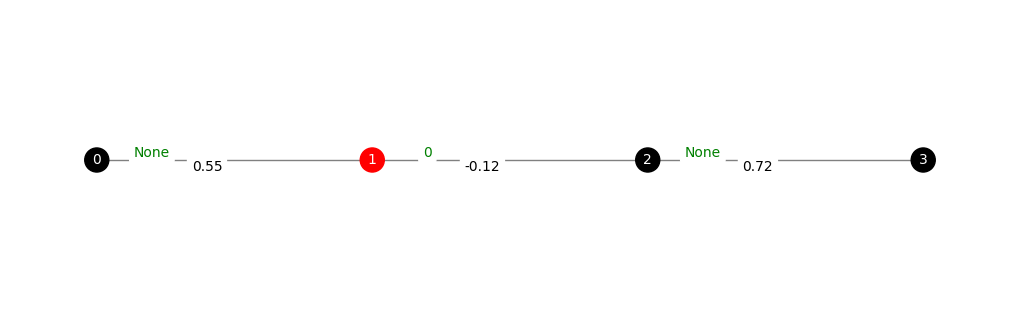

In [7]:
rng = np.random.default_rng(42)
G = get_graph(n_qubits, rng, graph_type)

positions = get_positions(n_qubits, graph_type)

# エッジラベルを作成
edge_J_labels = {edge: f"{G.edges[edge]['J']:.2g}" for edge in G.edges}
edge_cnot_order_labels = {edge: f"{G.edges[edge]['cnot']['order']}" for edge in G.edges}

# グラフを描画
plt.figure(figsize=(10, 3))
nx.draw(
    G,
    pos=positions,
    with_labels=True,
    node_color=["red" if G.nodes[node]["hadamard"] else "black" for node in G.nodes],
    node_size=300,
    edge_color="gray",
    font_color="white",
    font_size=10,
)

# エッジの重みを描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_J_labels,
    font_size=10,
    font_color="black",
    label_pos=0.6,
    verticalalignment="top",
)

# エッジの 'cnot' 'order' 属性を描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_cnot_order_labels,
    font_size=10,
    font_color="green",
    label_pos=0.8,
    verticalalignment="bottom",
)

plt.show()

In [8]:
# State |0011...1100> (center qubits are 1 and the rest are 0)
leftmost = n_qubits // 4
rightmost = leftmost + n_qubits // 2 - 1
index = []
for i in range(n_qubits):
    if leftmost <= i <= rightmost:
        index.append("1")
    else:
        index.append("0")

index = "".join(index)
print(f"binary index: {index}")
state = Statevector.from_label(index)

print(f"decimal: {int(index, 2)}")
print(state[int(index, 2)])

binary index: 0110
decimal: 6
(1+0j)


## Non Trotter simulation (directly compute the expectation value)

In [9]:
data = []
graphs = []
# For debugging
# eigvals_abs_max = []
rng = np.random.default_rng(42)

for i in range(n_samples):
    print(f"Sample {i}/{n_samples}")
    G = get_graph(n_qubits, rng, graph_type)
    Js = [G.edges[edge]["J"] for edge in G.edges]
    heisenberg = HeisenbergModel(n_qubits, G)

    H = heisenberg.H
    # H = H.to_matrix(sparse=True)

    # state is big endian, so we need to reverse the qubits of the Hamiltonian
    H = Operator(H).reverse_qargs().to_matrix()
    H = scipy.sparse.csr_matrix(H)
    norm = scipy.sparse.linalg.norm(H, ord=2)

    fH = scipy.sparse.linalg.expm(-beta * H)
    # Compute the expectation value <state|exp(-beta*H)|state>
    y = np.vdot(state, fH @ state).real

    data.append({"Js": Js, "expected_value": y, "norm": norm})
    graphs.append(G)

    # For debugging
    # eigvals_abs_max.append(max(np.abs(scipy.linalg.eigvals(H.toarray()))))

df = pd.DataFrame(data)
df

Sample 0/70
Sample 1/70
Sample 2/70
Sample 3/70
Sample 4/70
Sample 5/70
Sample 6/70
Sample 7/70
Sample 8/70
Sample 9/70
Sample 10/70
Sample 11/70
Sample 12/70
Sample 13/70
Sample 14/70
Sample 15/70
Sample 16/70
Sample 17/70
Sample 18/70
Sample 19/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Sample 20/70
Sample 21/70
Sample 22/70
Sample 23/70
Sample 24/70
Sample 25/70
Sample 26/70
Sample 27/70
Sample 28/70
Sample 29/70
Sample 30/70
Sample 31/70
Sample 32/70
Sample 33/70
Sample 34/70
Sample 35/70
Sample 36/70
Sample 37/70
Sample 38/70
Sample 39/70
Sample 40/70
Sample 41/70
Sample 42/70
Sample 43/70
Sample 44/70
Sample 45/70
Sample 46/70
Sample 47/70
Sample 48/70
Sample 49/70
Sample 50/70
Sample 51/70
Sample 52/70
Sample 53/70
Sample 54/70
Sample 55/70
Sample 56/70
Sample 57/70
Sample 58/70
Sample 59/70
Sample 60/70
Sample 61/70
Sample 62/70
Sample 63/70
Sample 64/70
Sample 65/70
Sample 66/70
Sample 67/70
Sample 68/70
Sample 69/70


,Js,expected_value,norm
0,"[0.5479120971119267, -0.12224312049589536, 0.7...",13.899220,3.803761
1,"[0.3947360581187278, -0.8116453042247009, 0.95...",28.585213,4.309460
2,"[0.5222794039807059, 0.5721286105539076, -0.74...",2.653082,2.959087
3,"[-0.09922812420886573, -0.25840395153483753, 0...",7.222891,2.708653
4,"[0.2877302401613291, 0.64552322654166, -0.1131...",0.865078,2.096133
...,...,...,...
65,"[-0.6414633836845218, 0.198765583041687, 0.749...",4.736264,2.925928
66,"[-0.6071306685708535, -0.37935265419981046, 0....",3.702486,2.560024
67,"[0.9436528521219347, 0.0014823724046846287, -0...",9.349640,3.543165
68,"[-0.9721274245835969, -0.5406879400022895, -0....",2.038295,5.274069


## Pre-process data

In [10]:
df["expected_value"].describe()

count    70.000000
mean      4.468657
std       5.671422
min       0.527533
25%       1.482304
50%       2.249900
75%       4.502295
max      28.585213
Name: expected_value, dtype: float64

In [11]:
df["norm"].describe()

count    70.000000
mean      2.961937
std       0.845948
min       1.164527
25%       2.316886
50%       2.942507
75%       3.457458
max       5.274069
Name: norm, dtype: float64

In [12]:
# Query the 80% quantile
q = df["expected_value"].quantile(0.8)
filtered_index = df.query(f"expected_value < @q").index
diffrence = df.index.difference(filtered_index)
print(f"Outliers: {diffrence}")

# Remove outliers
df = df.drop(diffrence).reset_index(drop=True)
graphs = [graph for i, graph in enumerate(graphs) if i not in diffrence]

Outliers: Index([0, 1, 3, 6, 13, 14, 24, 33, 43, 46, 53, 57, 59, 67], dtype='int64')


In [13]:
display(df)

n_samples = len(df)
print(f"Number of samples: {n_samples}")
df["expected_value"].describe()

,Js,expected_value,norm
0,"[0.5222794039807059, 0.5721286105539076, -0.74...",2.653082,2.959087
1,"[0.2877302401613291, 0.64552322654166, -0.1131...",0.865078,2.096133
2,"[-0.5455225564304462, 0.1091695740316696, -0.8...",1.138950,4.259728
3,"[-0.2909480637402633, 0.9413960487898065, 0.78...",4.367027,3.666207
4,"[0.5567669941475237, -0.6107225842960649, -0.0...",4.566077,2.099758
5,"[-0.9123924684255424, -0.6914210158649043, 0.3...",3.720380,3.561412
6,"[0.48952431181563427, 0.93501946486842, -0.348...",1.711405,3.218417
7,"[-0.25908058793026223, -0.06088837744838416, -...",0.920606,2.643683
8,"[-0.7401569893290567, -0.04859014754813251, -0...",1.084233,3.860418
9,"[0.6095287149936037, -0.22504324193965108, -0....",3.526609,2.297825


Number of samples: 56


count    56.000000
mean      2.248627
std       1.204008
min       0.527533
25%       1.295174
50%       2.026028
75%       2.779758
max       5.025722
Name: expected_value, dtype: float64

In [ ]:
df["norm"].describe()

count    56.000000
mean      2.802978
std       0.812152
min       1.164527
25%       2.098052
50%       2.790209
75%       3.360367
max       5.274069
Name: norm, dtype: float64

## Check eigvals and Configure params

In [ ]:
n_features = 10  # Number of Fourier features

# Parameters for the Fourier feature generation
# For shifted Hamiltonian
# C = 20 * n_qubits  # upper bound for eigenvalues (WHY?)
# times = [2 * np.pi * k / C for k in range(n_features)]

# For unshifted Hamiltonian
# C = 10 * n_qubits  # upper bound for eigenvalues
# C = max(df["norm"]) * 10
C = max(df["norm"])
times = [np.pi * k / C for k in range(n_features)]

print(f"C: {C}")
print(f"times: {times}")

C: 5.274068563211588
times: [0.0, 0.5956677688082146, 1.1913355376164292, 1.787003306424644, 2.3826710752328584, 2.9783388440410734, 3.574006612849288, 4.169674381657503, 4.765342150465717, 5.361009919273932]


In [16]:
# Only for using Docker container
%cd fourier_learning_ibm/

/home/jovyan/fourier_learning_ibm


In [ ]:
CURRENT_TIME = (
    datetime.now(timezone.utc).isoformat(timespec="minutes").replace("+00:00", "Z")
)

path = f"./data/{CURRENT_TIME}"
os.makedirs(path, exist_ok=True)
print("Note: This CURRENT_TIME is used for other notebooks.")
print(f"CURRENT_TIME: {CURRENT_TIME}")
print(f"Saving data to {path}")

Note: This CURRENT_TIME is used for other notebooks.
CURRENT_TIME: 2024-12-21T09:50Z
Saving data to ./data/2024-12-21T09:50Z


In [18]:
# Save parameters

# Save the graphs as a binary file
with open(f"{path}/params_object.pkl", "wb") as f:
    pickle.dump(
        {
            "graphs": graphs,
            "Js": df["Js"].values,
            "expected_values": df["expected_value"].values,
        },
        f,
    )

# Save the parameters as a JSON file
with open(f"{path}/params_text.json", "w") as f:
    json.dump(
        {
            "n_samples": n_samples,
            "n_qubits": n_qubits,
            "graph_type": graph_type,
            "backend_qpu_name": backend_qpu.name,
            "beta": beta,
            "C": C,
            "n_features": n_features,
            "times": times,
        },
        f,
        indent=4,
    )